In this notebook we build a convolutional neural network (CNN) model to recognize and classify satellite images of the Amazon rainforest.<BR>
We use the image data processed in the [data pre-processing notebook](./AmazonForest-data-process.ipynb) to build and train the model.<BR><BR>
The model is trained on a 8vCPUs x 32GB RAM virtual machine; the system does not have any GPUs.

#### Lets first load the required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from utils import data_utils, model_utils, plot_utils
%matplotlib inline

#### Configure the number of CPU threads to be used by independent non-blocking operations:

In [2]:
num_threads = 8
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

#### Load the csv containing the target labels to a pandas dataframe

In [3]:
!ls data/train_labels.csv

data/train_labels.csv


In [4]:
df_target = pd.read_csv('data/train_labels.csv')
df_target.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [5]:
categories = list(df_target.select_dtypes(include='int64').columns)

In [6]:
categories

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

The dataset has 17 distinct class labels.<BR>
For a description of these labels please see the [data pre-processing notebook](./AmazonForest-data-process.ipynb) 

#### Load the data saved in the npz files during the pre-processing step
* Load the individual npz files,
* Retreive the data from these,
* Stack the data to create the numpy arrays corresponding to all the images and the labels.

In [7]:
%%time
file_path = 'data/amazon_forest_part*npz'
X, Y = data_utils.load_data(file_path)

CPU times: user 13.1 s, sys: 830 ms, total: 13.9 s
Wall time: 13.9 s


In [8]:
X.shape

(40479, 128, 128, 3)

In [9]:
Y.shape

(40479, 17)

The X numpy array consists of the 40479 images, each image represeted as a 128x128x3 array<BR>
The Y array contains the labels corresponding to the images

#### Split the data into train and test data sets

In [10]:
%%time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

CPU times: user 208 ms, sys: 332 ms, total: 541 ms
Wall time: 540 ms


#### Resacle the data from [0,255] --> [0,1]
* Normalize the data so that each pixel in the X_train and X_test arrays is scaled to a value between [0,1]

In [11]:
%%time

X_train = data_utils.rescale_data(X_train)
X_test = data_utils.rescale_data(X_test)

CPU times: user 1.16 s, sys: 1.31 s, total: 2.47 s
Wall time: 2.47 s


In [12]:
X_train.shape, X_test.shape

((32383, 128, 128, 3), (8096, 128, 128, 3))

In [13]:
Y_train.shape, Y_test.shape

((32383, 17), (8096, 17))

Now that we have created the train and test datasets, lets delete the original X and Y arrays to free up some memory

In [14]:
del X; del Y

#### Split the train dataset into train and validation sets
* We will use 20% of the training dataset as validation data during the model training phase

In [15]:
tr_size = X_train.shape[0] - int(0.2 * X_train.shape[0])

In [16]:
(X_train, X_valid) = X_train[:tr_size], X_train[tr_size:]
(Y_train, Y_valid) = Y_train[:tr_size], Y_train[tr_size:]

In [17]:
X_train.shape, X_valid.shape

((25907, 128, 128, 3), (6476, 128, 128, 3))

In [18]:
Y_train.shape, Y_valid.shape

((25907, 17), (6476, 17))

#### Define a metric for measuring the model performance
* As seen during the data [pre-processing stage](./AmazonForest-data-process.ipynb) the dataset is a multi-labeled and highly imbalanced dataset with some class labels occuring more frequently than others.
* Given the imbalanced nature of the data, classification accuracy could be a misleading metric when evaluating the model performance.
* Instead, we will use the F1-score as the metric to measure the model performance.
* The F1-score considers both precision and recall, to get a high F1-score both false positives and false negatives should be low. 

We have defined the precision(), recall(), fbeta_score() functions in the model_utils module.<BR><BR>
During the training phase the fbeta_score function is invoked with beta=1 to compute the F1-score during each training epoch.

#### Create the CNN model
##### Model Architecture
* We use the Keras Sequential API to create the model.
* The model architecture, loosely based on the VGG network, consists of 3 blocks each block made of 2 CNN layers followed by a MaxPool layer, and a Dropout layer.
* The CNN layers in the 1st block consist of 32 filters, in the 2nd block 64 filters, and in the 3rd block 128 filters.
* We use a size 3x3 kernel for the convolution operation, with padding parameter set to 'same'
* The activation function used with the CNN layers is 'relu'
* The CNN layers extract the features from the image dataset and build the feature/activation maps
* The MaxPool layers operate on the feature maps created by the CNN layer, and help keep the number of parameters low.
* The Dropout layers reduce overfitting by dropping some nodes during the training. We configure the Dropout layer to drop 20% of nodes randomly during the training process.
* The output from the 3rd block is flatenned and fed to two fully connected (FC) layers, each with 128 nodes.
* The final output layer consists of 17 nodes as our dataset consists of 17 classification labels.
* As this is a multi-label classification problem the activation function used is sigmoid, and the loss function used is binary cross-entropy.
* The optimizer used is the mini-batch stochastic gradient descent optimizer with learning rate 0.01 and momentum 0.9
* As indicated earlier, the fbeta_score function defined in the model_utils module is used to measure the model performance at each epoch of training.
  
  

In [19]:
%%time

input_shape = (128, 128, 3)
output_shape = 17

#create the model
model = model_utils.create_model(input_shape, output_shape)
model.summary()

2022-05-31 21:59:17.598124: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

#### Train the model
* The model.fit() method is used to train the model.
* The data is divided into batches of batch_size=128, the number of epochs set to 60.
* The validation holdout set created earlier will be used at the end of each epoch to compute the validation loss and validation score.
* The ModelCheckPoint() callback is invoked to evaluate the validation loss at end of each epoch, and save the best model thus far.

In [20]:
%%time

batch_size = 128
epochs = 60
best_model = 'amzn_forest.best.hdf5'

checkpointer = ModelCheckpoint(filepath=best_model, verbose=1, 
                               save_best_only=True)

hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_valid, Y_valid), callbacks=[checkpointer, TqdmCallback(verbose=2)], 
                 verbose=2, shuffle=True)
    

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 1/60

Epoch 1: val_loss improved from inf to 0.24749, saving model to amzn_forest.best.hdf5
203/203 - 470s - loss: 0.3063 - fbeta_score: 0.6298 - val_loss: 0.2475 - val_fbeta_score: 0.6733 - 470s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 2/60

Epoch 2: val_loss improved from 0.24749 to 0.24140, saving model to amzn_forest.best.hdf5
203/203 - 467s - loss: 0.2434 - fbeta_score: 0.6688 - val_loss: 0.2414 - val_fbeta_score: 0.6733 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 3/60

Epoch 3: val_loss improved from 0.24140 to 0.24031, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.2394 - fbeta_score: 0.6690 - val_loss: 0.2403 - val_fbeta_score: 0.6737 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 4/60

Epoch 4: val_loss improved from 0.24031 to 0.23253, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.2288 - fbeta_score: 0.6663 - val_loss: 0.2325 - val_fbeta_score: 0.6752 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 5/60

Epoch 5: val_loss improved from 0.23253 to 0.23009, saving model to amzn_forest.best.hdf5
203/203 - 468s - loss: 0.2229 - fbeta_score: 0.6765 - val_loss: 0.2301 - val_fbeta_score: 0.6835 - 468s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 6/60

Epoch 6: val_loss improved from 0.23009 to 0.22566, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.2204 - fbeta_score: 0.6831 - val_loss: 0.2257 - val_fbeta_score: 0.6968 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 7/60

Epoch 7: val_loss improved from 0.22566 to 0.22062, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.2187 - fbeta_score: 0.6864 - val_loss: 0.2206 - val_fbeta_score: 0.6839 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 8/60

Epoch 8: val_loss improved from 0.22062 to 0.21936, saving model to amzn_forest.best.hdf5
203/203 - 462s - loss: 0.2159 - fbeta_score: 0.6935 - val_loss: 0.2194 - val_fbeta_score: 0.7109 - 462s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 9/60

Epoch 9: val_loss improved from 0.21936 to 0.21471, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.2125 - fbeta_score: 0.7050 - val_loss: 0.2147 - val_fbeta_score: 0.7213 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 10/60

Epoch 10: val_loss improved from 0.21471 to 0.21007, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.2070 - fbeta_score: 0.7218 - val_loss: 0.2101 - val_fbeta_score: 0.7376 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 11/60

Epoch 11: val_loss did not improve from 0.21007
203/203 - 466s - loss: 0.2027 - fbeta_score: 0.7324 - val_loss: 0.2103 - val_fbeta_score: 0.7422 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 12/60

Epoch 12: val_loss improved from 0.21007 to 0.19865, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1986 - fbeta_score: 0.7412 - val_loss: 0.1987 - val_fbeta_score: 0.7467 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 13/60

Epoch 13: val_loss improved from 0.19865 to 0.19309, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1943 - fbeta_score: 0.7497 - val_loss: 0.1931 - val_fbeta_score: 0.7572 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 14/60

Epoch 14: val_loss improved from 0.19309 to 0.19005, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1917 - fbeta_score: 0.7530 - val_loss: 0.1900 - val_fbeta_score: 0.7640 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 15/60

Epoch 15: val_loss improved from 0.19005 to 0.18730, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1888 - fbeta_score: 0.7572 - val_loss: 0.1873 - val_fbeta_score: 0.7597 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 16/60

Epoch 16: val_loss did not improve from 0.18730
203/203 - 463s - loss: 0.1858 - fbeta_score: 0.7619 - val_loss: 0.1892 - val_fbeta_score: 0.7702 - 463s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 17/60

Epoch 17: val_loss did not improve from 0.18730
203/203 - 469s - loss: 0.1831 - fbeta_score: 0.7643 - val_loss: 0.1876 - val_fbeta_score: 0.7640 - 469s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 18/60

Epoch 18: val_loss improved from 0.18730 to 0.18623, saving model to amzn_forest.best.hdf5
203/203 - 468s - loss: 0.1813 - fbeta_score: 0.7662 - val_loss: 0.1862 - val_fbeta_score: 0.7754 - 468s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 19/60

Epoch 19: val_loss improved from 0.18623 to 0.17868, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1782 - fbeta_score: 0.7694 - val_loss: 0.1787 - val_fbeta_score: 0.7799 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 20/60

Epoch 20: val_loss improved from 0.17868 to 0.17663, saving model to amzn_forest.best.hdf5
203/203 - 464s - loss: 0.1762 - fbeta_score: 0.7729 - val_loss: 0.1766 - val_fbeta_score: 0.7758 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 21/60

Epoch 21: val_loss improved from 0.17663 to 0.17517, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1746 - fbeta_score: 0.7741 - val_loss: 0.1752 - val_fbeta_score: 0.7831 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 22/60

Epoch 22: val_loss improved from 0.17517 to 0.17155, saving model to amzn_forest.best.hdf5
203/203 - 467s - loss: 0.1716 - fbeta_score: 0.7791 - val_loss: 0.1716 - val_fbeta_score: 0.7818 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 23/60

Epoch 23: val_loss improved from 0.17155 to 0.17154, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1703 - fbeta_score: 0.7803 - val_loss: 0.1715 - val_fbeta_score: 0.7795 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 24/60

Epoch 24: val_loss did not improve from 0.17154
203/203 - 464s - loss: 0.1681 - fbeta_score: 0.7823 - val_loss: 0.1727 - val_fbeta_score: 0.7891 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 25/60

Epoch 25: val_loss improved from 0.17154 to 0.17029, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1663 - fbeta_score: 0.7864 - val_loss: 0.1703 - val_fbeta_score: 0.7893 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 26/60

Epoch 26: val_loss improved from 0.17029 to 0.16695, saving model to amzn_forest.best.hdf5
203/203 - 464s - loss: 0.1652 - fbeta_score: 0.7881 - val_loss: 0.1669 - val_fbeta_score: 0.7899 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 27/60

Epoch 27: val_loss did not improve from 0.16695
203/203 - 466s - loss: 0.1634 - fbeta_score: 0.7896 - val_loss: 0.1673 - val_fbeta_score: 0.7849 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 28/60

Epoch 28: val_loss improved from 0.16695 to 0.16675, saving model to amzn_forest.best.hdf5
203/203 - 467s - loss: 0.1620 - fbeta_score: 0.7923 - val_loss: 0.1668 - val_fbeta_score: 0.7911 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 29/60

Epoch 29: val_loss improved from 0.16675 to 0.16360, saving model to amzn_forest.best.hdf5
203/203 - 468s - loss: 0.1600 - fbeta_score: 0.7942 - val_loss: 0.1636 - val_fbeta_score: 0.7890 - 468s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 30/60

Epoch 30: val_loss did not improve from 0.16360
203/203 - 466s - loss: 0.1591 - fbeta_score: 0.7956 - val_loss: 0.1682 - val_fbeta_score: 0.7863 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 31/60

Epoch 31: val_loss improved from 0.16360 to 0.16261, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1585 - fbeta_score: 0.7971 - val_loss: 0.1626 - val_fbeta_score: 0.7953 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 32/60

Epoch 32: val_loss improved from 0.16261 to 0.16257, saving model to amzn_forest.best.hdf5
203/203 - 465s - loss: 0.1569 - fbeta_score: 0.7991 - val_loss: 0.1626 - val_fbeta_score: 0.7990 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 33/60

Epoch 33: val_loss improved from 0.16257 to 0.16138, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1565 - fbeta_score: 0.7990 - val_loss: 0.1614 - val_fbeta_score: 0.7925 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 34/60

Epoch 34: val_loss improved from 0.16138 to 0.15922, saving model to amzn_forest.best.hdf5
203/203 - 464s - loss: 0.1535 - fbeta_score: 0.8040 - val_loss: 0.1592 - val_fbeta_score: 0.7998 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 35/60

Epoch 35: val_loss did not improve from 0.15922
203/203 - 465s - loss: 0.1528 - fbeta_score: 0.8036 - val_loss: 0.1593 - val_fbeta_score: 0.7913 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 36/60

Epoch 36: val_loss improved from 0.15922 to 0.15814, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1512 - fbeta_score: 0.8060 - val_loss: 0.1581 - val_fbeta_score: 0.8052 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 37/60

Epoch 37: val_loss did not improve from 0.15814
203/203 - 466s - loss: 0.1509 - fbeta_score: 0.8076 - val_loss: 0.1600 - val_fbeta_score: 0.7893 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 38/60

Epoch 38: val_loss did not improve from 0.15814
203/203 - 463s - loss: 0.1494 - fbeta_score: 0.8080 - val_loss: 0.1588 - val_fbeta_score: 0.8003 - 463s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 39/60

Epoch 39: val_loss improved from 0.15814 to 0.15545, saving model to amzn_forest.best.hdf5
203/203 - 464s - loss: 0.1476 - fbeta_score: 0.8111 - val_loss: 0.1555 - val_fbeta_score: 0.8061 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 40/60

Epoch 40: val_loss did not improve from 0.15545
203/203 - 463s - loss: 0.1470 - fbeta_score: 0.8129 - val_loss: 0.1583 - val_fbeta_score: 0.7992 - 463s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 41/60

Epoch 41: val_loss did not improve from 0.15545
203/203 - 466s - loss: 0.1462 - fbeta_score: 0.8134 - val_loss: 0.1558 - val_fbeta_score: 0.8067 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 42/60

Epoch 42: val_loss improved from 0.15545 to 0.15257, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1442 - fbeta_score: 0.8164 - val_loss: 0.1526 - val_fbeta_score: 0.8090 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 43/60

Epoch 43: val_loss did not improve from 0.15257
203/203 - 466s - loss: 0.1434 - fbeta_score: 0.8179 - val_loss: 0.1543 - val_fbeta_score: 0.8018 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 44/60

Epoch 44: val_loss did not improve from 0.15257
203/203 - 466s - loss: 0.1419 - fbeta_score: 0.8195 - val_loss: 0.1564 - val_fbeta_score: 0.7994 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 45/60

Epoch 45: val_loss did not improve from 0.15257
203/203 - 465s - loss: 0.1405 - fbeta_score: 0.8210 - val_loss: 0.1545 - val_fbeta_score: 0.8137 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 46/60

Epoch 46: val_loss did not improve from 0.15257
203/203 - 466s - loss: 0.1395 - fbeta_score: 0.8227 - val_loss: 0.1547 - val_fbeta_score: 0.8025 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 47/60

Epoch 47: val_loss did not improve from 0.15257
203/203 - 465s - loss: 0.1395 - fbeta_score: 0.8233 - val_loss: 0.1543 - val_fbeta_score: 0.8067 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 48/60

Epoch 48: val_loss did not improve from 0.15257
203/203 - 465s - loss: 0.1376 - fbeta_score: 0.8254 - val_loss: 0.1599 - val_fbeta_score: 0.8000 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 49/60

Epoch 49: val_loss improved from 0.15257 to 0.15221, saving model to amzn_forest.best.hdf5
203/203 - 466s - loss: 0.1358 - fbeta_score: 0.8280 - val_loss: 0.1522 - val_fbeta_score: 0.8111 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 50/60

Epoch 50: val_loss did not improve from 0.15221
203/203 - 467s - loss: 0.1356 - fbeta_score: 0.8277 - val_loss: 0.1549 - val_fbeta_score: 0.8055 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 51/60

Epoch 51: val_loss improved from 0.15221 to 0.15145, saving model to amzn_forest.best.hdf5
203/203 - 467s - loss: 0.1342 - fbeta_score: 0.8294 - val_loss: 0.1514 - val_fbeta_score: 0.8088 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 52/60

Epoch 52: val_loss did not improve from 0.15145
203/203 - 466s - loss: 0.1331 - fbeta_score: 0.8314 - val_loss: 0.1532 - val_fbeta_score: 0.8095 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 53/60

Epoch 53: val_loss did not improve from 0.15145
203/203 - 466s - loss: 0.1322 - fbeta_score: 0.8320 - val_loss: 0.1546 - val_fbeta_score: 0.8078 - 466s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 54/60

Epoch 54: val_loss did not improve from 0.15145
203/203 - 468s - loss: 0.1308 - fbeta_score: 0.8358 - val_loss: 0.1556 - val_fbeta_score: 0.8083 - 468s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 55/60

Epoch 55: val_loss did not improve from 0.15145
203/203 - 467s - loss: 0.1294 - fbeta_score: 0.8369 - val_loss: 0.1531 - val_fbeta_score: 0.8103 - 467s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 56/60

Epoch 56: val_loss did not improve from 0.15145
203/203 - 463s - loss: 0.1277 - fbeta_score: 0.8389 - val_loss: 0.1528 - val_fbeta_score: 0.8145 - 463s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 57/60

Epoch 57: val_loss did not improve from 0.15145
203/203 - 465s - loss: 0.1271 - fbeta_score: 0.8413 - val_loss: 0.1545 - val_fbeta_score: 0.8102 - 465s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 58/60

Epoch 58: val_loss did not improve from 0.15145
203/203 - 464s - loss: 0.1256 - fbeta_score: 0.8417 - val_loss: 0.1551 - val_fbeta_score: 0.8069 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 59/60

Epoch 59: val_loss did not improve from 0.15145
203/203 - 464s - loss: 0.1240 - fbeta_score: 0.8443 - val_loss: 0.1552 - val_fbeta_score: 0.8062 - 464s/epoch - 2s/step


  0%|          | 0.00/203 [00:00<?, ?batch/s]

Epoch 60/60

Epoch 60: val_loss did not improve from 0.15145
203/203 - 467s - loss: 0.1227 - fbeta_score: 0.8472 - val_loss: 0.1547 - val_fbeta_score: 0.8079 - 467s/epoch - 2s/step
CPU times: user 1d 21h 28min 6s, sys: 15h 47min 3s, total: 2d 13h 15min 9s
Wall time: 7h 46min 24s


#### Plot the model performance
* The 'history callback' object returned by the model.fit() method keeps track of loss, performance and other training metrics.
* The plot_model_perf() function uses the history and the matplotlib library to plot the loss and the F1-score at the end of each ecpoch for both the training dataset and the validation dataset.

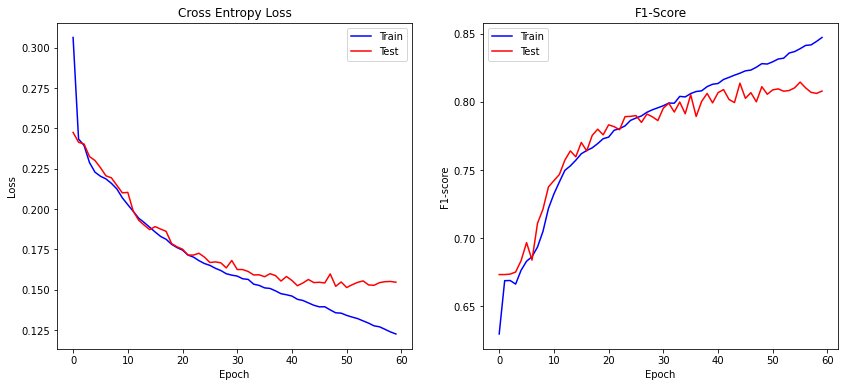

In [21]:
#plot the model performance
plot_utils.plot_model_perf(hist)

* We see from the above graphs that as the training progressed the performance of the training dataset improved
* We see a steady decrease in the cross entropy loss and a steady increase in the F1-score for the training dataset.
* But on the other hand the performance of the validation dataset, shown by the red curves in the graphs, ceases to improve after a certain period of time.
* After about the 50th epoch, the cross-entropy loss tends to increase and the F1-score tends to decrease for the validation dataset.
* This indicates the model has overfit the training dataset and is not able to generalize well to the holdout validation dataset.
* We had introduced Dropout layers in the model architecture to prevent the model from overfitting, but as we see the issue is not fully addressed.
* In the next notebook we further look into the overfitting issue and additional techniques to prevent the model from overfitting.

#### Lets load the weights that yielded the best score

In [22]:
%%time
model.load_weights('amzn_forest.best.hdf5')

CPU times: user 9.2 ms, sys: 8.59 ms, total: 17.8 ms
Wall time: 16.9 ms


#### Evaluate and print the score

In [23]:
%%time
score = model.evaluate(X_test, Y_test, verbose=0)
print('Loss:', score[0])
print('F1-score:', score[1])

Loss: 0.15046843886375427
F1-score: 0.805839478969574
CPU times: user 3min 39s, sys: 1min 59s, total: 5min 38s
Wall time: 43.5 s


The model has a F1-score of 0.805, i.e approx 81%, and a loss of 0.15

#### Let's plot the predicted labels for the some of the images in the Test dataset and compare with the actual labels

* Lets first compute the predicted labels for the first 12 images:

In [24]:
num = 12
Y_pred = model.predict(X_test[0:num])
Y_pred  = Y_pred.round()

* In the image plots below the predicted labels are displayed on the top of each image, and the true lables at the bottom.
* If the predicted does not match the true label, its marked in red.  

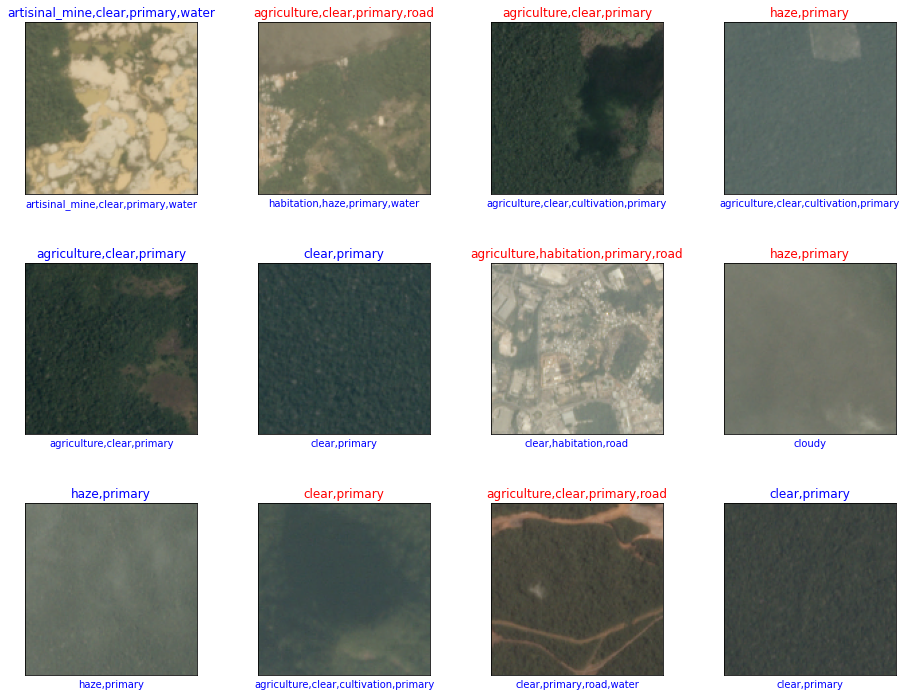

In [25]:
plot_utils.plot_predictions(X_test, Y_test, Y_pred, categories, num)

In the [next notebook](./AmazonForest-model-train-V2.ipynb) we  look into the overfitting issue observed during training and techniques to prevent the model from overfitting.